# Shear building model
We consider a shear building under seismic excitations. The dynamical response of a 2 storey building can be described by the following equations:

$$
\begin{align}
m\ddot{x}_1(t)+c_1 \dot{x}_1 + k(2x_1(t)-x_2(t)) = -mb(t),\\
m\ddot{x}_2(t)+c_2 \dot{x}_2 + k(x_2(t)-x_1(t)) = -mb(t),\\
\end{align}
$$

where $m=625$ ton is the mass of each floor; $k$ is the inter-storey stiffness; $b(t)$ is the ground acceleration signal; $c_1$ and $c_2$ are coefficients set to have $1\%$ damping over the two eigenmodes of the building model.

We suppose we are able to measure displacements, velocities and accelerations of the two floors, and we aim to:

1. **Identify the equations of motion from the data (SINDy)**
2. **Estimate the states and the inter-storey stiffness $k$ (EKF-SINDy)**

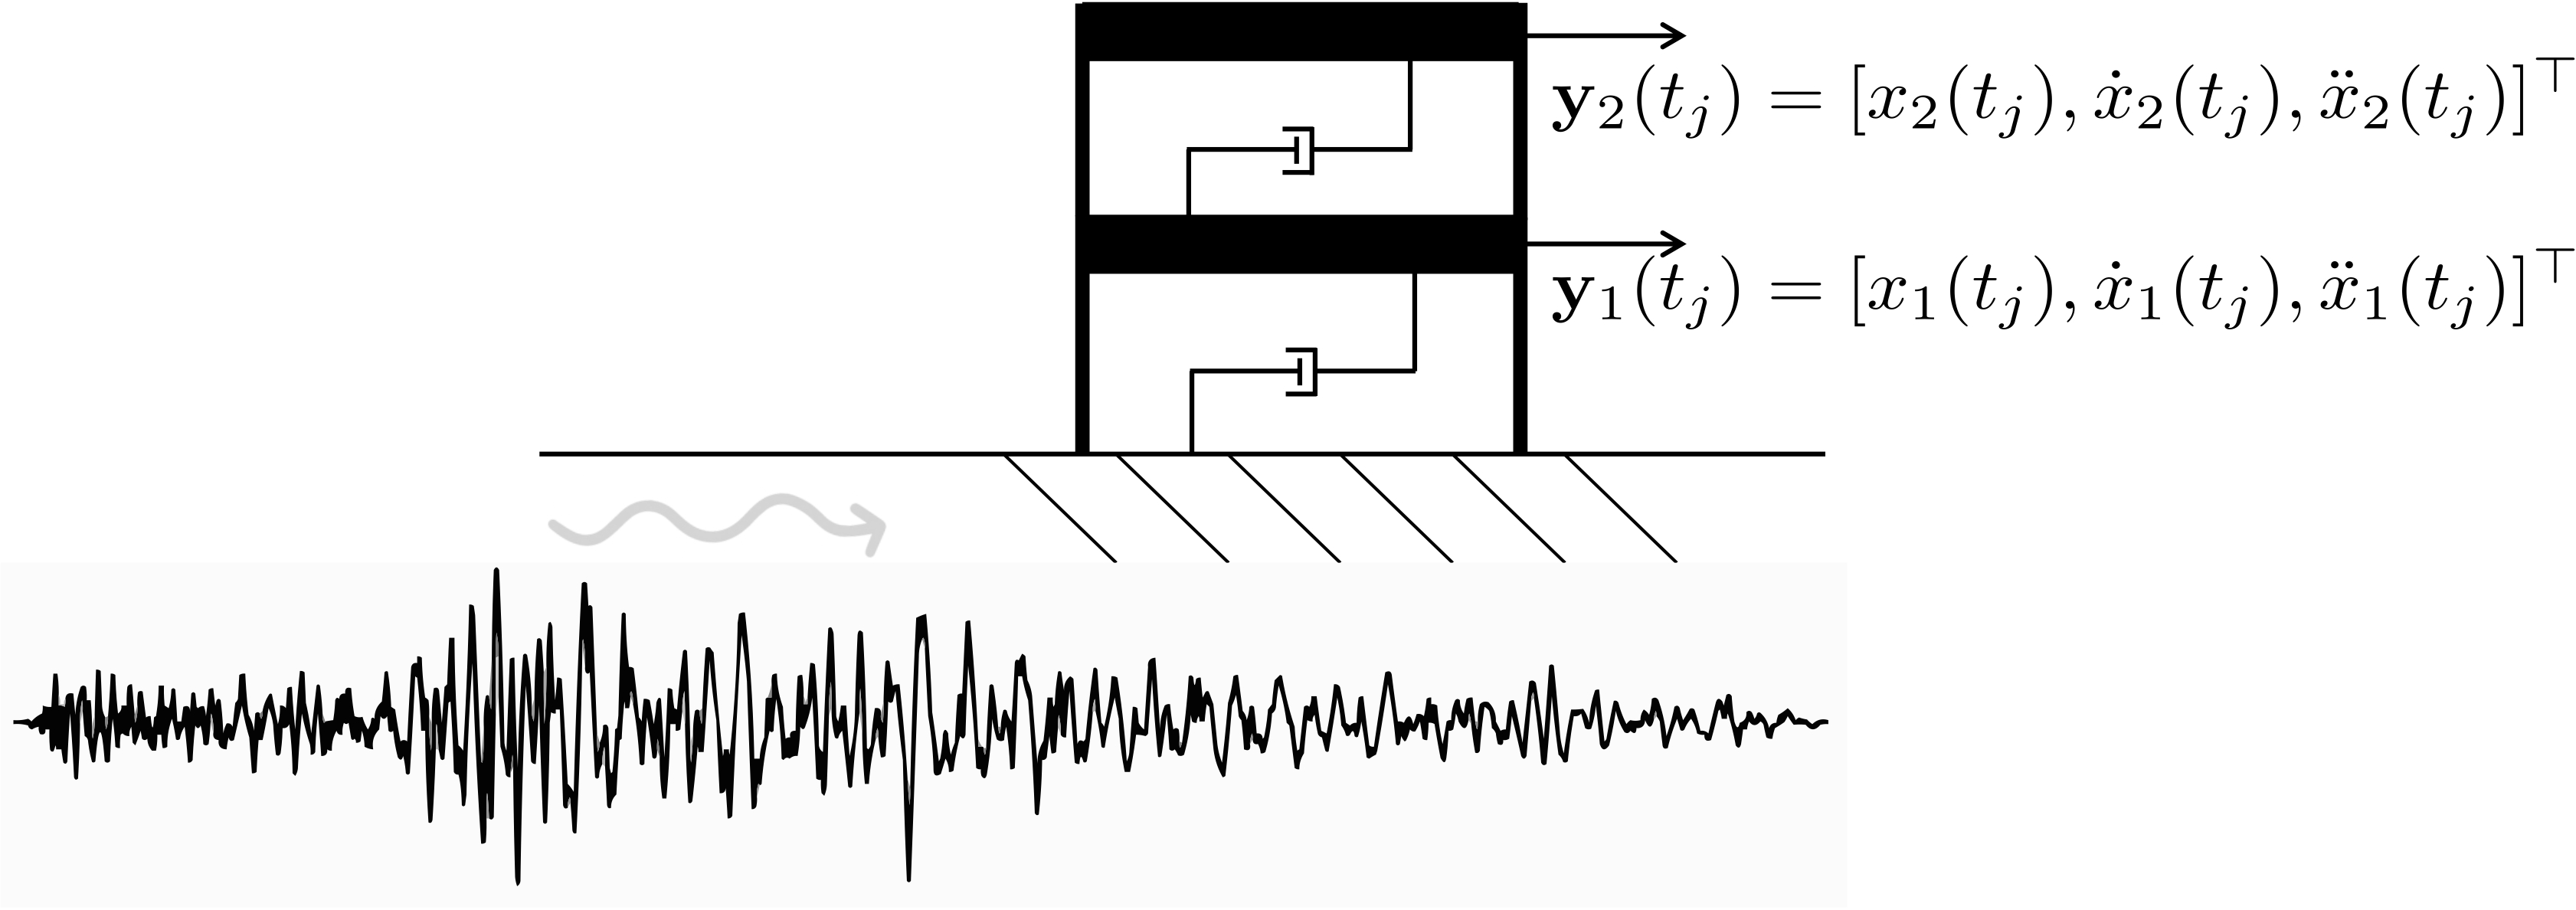

In [1]:
from IPython.display import display, Image

display(Image(filename='./shear_model.jpg'))

### Download data
Download data at https://zenodo.org/records/11581079 and put them in train and test directories

In [2]:
###########################                LIBRARIES                ###########################
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import copy

from utils_ShearBuilding import read_data, add_noise_with_snr, ass_xhat, ass_inputs_Euler_forward, output_obs, jacobian_A, model_Asindy, model_Bsindy_f, model_Hsindy, model_Hsindy_f, jacobian_H

seed = 1

# Change your train and test directories accordingly!
root_data_train = r"C:\Users\paolo\PhD\Projects\Rosafalco\EKF-SINDy\EKF-SINDy\ShearBuilding_data\train"
root_data_test =  r"C:\Users\paolo\PhD\Projects\Rosafalco\EKF-SINDy\EKF-SINDy\ShearBuilding_data\test"


In [3]:
###########################                SETUP                ###########################
# Dimension of displacement, velocity and acceleration
N_ou = 2 
N_ov = 2
N_oa = 2
N_o = N_ou+N_ov+N_oa  # overall dimension of the system variables

#We suppose to observe all the variables: displacement, velocity and acceleration
N_obs_u = 2
N_obs_v = 2
N_obs_a = 2
N_obs = N_obs_u + N_obs_v + N_obs_a # overall dimension of the observed variables

N_f = 2   # number of forcing terms
N_param = 1  # number of parameters

add_noise = True
snr_noise_displ = 15
snr_noise_veloc = 15
snr_noise_accel = 15


# displacement observations
Sd = np.array([[1,0],[0,1]])   # Sd [N_obs_u x N_ou]
# velocity observations
Sv = np.array([[1,0],[0,1]])   # Sv [N_obs_v x N_ov]
# acceleration observations
Sa = np.array([[1,0],[0,1]])   # Sa [N_obs_a x N_oa]


In [4]:
########################       LOAD TRAIN DATA      ###########################
T_train = 1000 # training series length
n_train = 5000 # number of training instances

U_train, _ = read_data(root_data_train,'_U_concat_',T_train,N_ou, 'train')
V_train, _ = read_data(root_data_train,'_V_concat_',T_train,N_ov,'train')
A_train, _ = read_data(root_data_train,'_A_concat_',T_train,N_oa,'train')
param_train, _  = read_data(root_data_train,'theta_',T_train,N_param,'train')
F_train, _ = read_data(root_data_train,'F_',T_train,N_f,'train')

Sensor _U_concat_ to be loaded: 1
Loaded sensor: _U_concat_ 1
Sensor _U_concat_ to be loaded: 2
Loaded sensor: _U_concat_ 2
Sensor _V_concat_ to be loaded: 1
Loaded sensor: _V_concat_ 1
Sensor _V_concat_ to be loaded: 2
Loaded sensor: _V_concat_ 2
Sensor _A_concat_ to be loaded: 1
Loaded sensor: _A_concat_ 1
Sensor _A_concat_ to be loaded: 2
Loaded sensor: _A_concat_ 2
Sensor theta_ to be loaded: 1
Loaded sensor: theta_ 1
Sensor F_ to be loaded: 1
Loaded sensor: F_ 1
Sensor F_ to be loaded: 2
Loaded sensor: F_ 2


In [5]:
########################       LOAD TEST DATA      ###########################
T = 40960 # testing series length
n_test = 20 # number of testing instances

U_test, _ = read_data(root_data_test,'_U_concat_',T,N_ou,'test')
if add_noise:
    U_test_noisefree = copy.copy(U_test)
    U_test = add_noise_with_snr(U_test,snr_noise_displ)
V_test, _ = read_data(root_data_test,'_V_concat_',T,N_ov,'test')
if add_noise:
    V_test_noisefree = copy.copy(V_test)
    V_test = add_noise_with_snr(V_test,snr_noise_veloc)
A_test, _ = read_data(root_data_test,'_A_concat_',T,N_oa,'test')
if add_noise:
    A_test_noisefree = copy.copy(A_test)
    A_test = add_noise_with_snr(A_test,snr_noise_accel)
param_test, _ = read_data(root_data_test,'theta_',T,N_param,'test')
F_test, _ = read_data(root_data_test,'F_',T,N_f, 'test')

Sensor _U_concat_ to be loaded: 1
Loaded sensor: _U_concat_ 1
Sensor _U_concat_ to be loaded: 2
Loaded sensor: _U_concat_ 2
Sensor _V_concat_ to be loaded: 1
Loaded sensor: _V_concat_ 1
Sensor _V_concat_ to be loaded: 2
Loaded sensor: _V_concat_ 2
Sensor _A_concat_ to be loaded: 1
Loaded sensor: _A_concat_ 1
Sensor _A_concat_ to be loaded: 2
Loaded sensor: _A_concat_ 2
Sensor theta_ to be loaded: 1
Loaded sensor: theta_ 1
Sensor F_ to be loaded: 1
Loaded sensor: F_ 1
Sensor F_ to be loaded: 2
Loaded sensor: F_ 2


In [6]:
########################       SCALE DATA      ###########################
scale_V = np.max(np.abs(V_train))
scale_F = np.max(np.abs(F_train))
scale_param = np.max(np.abs(param_train))

U_train_scaled = U_train / scale_V
V_train_scaled = V_train / scale_V
A_train_scaled = A_train / scale_V
F_train_scaled = F_train / scale_F
param_train_scaled = param_train / scale_param

scale_V_test = np.max(np.abs(V_test))
scale_F_test = np.max(np.abs(F_test))
scale_param_test = np.max(np.abs(param_test))

U_test_scaled = U_test / scale_V
V_test_scaled = V_test / scale_V
A_test_scaled = A_test / scale_V
F_test_scaled = F_test / scale_F
param_test_scaled = param_test / scale_param

U_test_scaled_noisefree = U_test_noisefree / scale_V
V_test_scaled_noisefree = V_test_noisefree / scale_V
A_test_scaled_noisefree = A_test_noisefree / scale_V

#We further scale the data for the maximum of the displacement
scale_x = np.max(np.abs(U_train_scaled))
x_train = U_train_scaled / scale_x
dx_train = V_train_scaled / scale_x
ddx_train = A_train_scaled / scale_x

x_test = U_test_scaled / scale_x
dx_test = V_test_scaled / scale_x
ddx_test = A_test_scaled / scale_x

x_test_noisefree = U_test_scaled_noisefree / scale_x
dx_test_noisefree = V_test_scaled_noisefree / scale_x
ddx_test_noisefree = A_test_scaled_noisefree / scale_x

data_train = {'U' : U_train_scaled, 'V' : V_train_scaled, 'A' : A_train_scaled, 'theta' : param_train_scaled, 'F' : F_train_scaled}
data_test = {'U' : U_test_scaled, 'V' : V_test_scaled, 'A' : A_test_scaled, 'theta' : param_test_scaled, 'F' : F_test_scaled}
data_test_noisefree = {'U' : U_test_scaled_noisefree, 'V' : V_test_scaled_noisefree, 'A' : A_test_scaled_noisefree}


In [7]:
######################      PREPARE DATA for SINDy       ######################
X = []
X_dot = []
params = []
dt = 0.001

feature_names = ["x1", "x2", "x1'", "x2'", "w0", "F1", "F2"]
sindy_library = [lambda x : x,

                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x1*x1,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x1*x2,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x1*x1_dot,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x1*x2_dot,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x1*w0,

                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x2*x2,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x2*x1_dot,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x2*x2_dot,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x2*w0,

                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x1_dot*x1_dot,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x1_dot*x2_dot,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x1_dot*w0,

                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x2_dot*x2_dot,
                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: x2_dot*w0,

                 lambda x1, x2, x1_dot, x2_dot, w0, F1, F2: w0*w0]

sindy_library_names = [
    "x1", "x2", "x1'", "x2'", "w0", "F1", "F2",
    "x1^2", "x1*x2", "x1*x1'", "x1*x2'", "x1*w0",
    "x2^2", "x2*x1'", "x2*x2'", "x2*w0",
    "x1'^2", "x1'*x2'", "x1'*w0",
    "x2'^2", "x2'*w0",
    "w0^2"
]


for i in range(n_train):
    X.append(np.concatenate((x_train[i], dx_train[i]*scale_x), axis = 1))
    X_dot.append(np.concatenate((dx_train[i],ddx_train[i]*scale_x), axis = 1)) 
    params.append(np.concatenate((param_train_scaled[i], F_train_scaled[i,:,0:1],F_train_scaled[i,:,1:2]), axis = 1))

feature_names = ["x1", "x2", "x1'", "x2'", "w0", "F1", "F2"]


In [8]:
######################      CREATE SINDy model       ######################
model = ps.SINDy(feature_names = sindy_library_names, feature_library= ps.CustomLibrary(library_functions = sindy_library), optimizer=ps.STLSQ(threshold=1e-2))
model.fit(X, t=dt, u = params, multiple_trajectories=True, x_dot = X_dot)
coeffs = model.coefficients()

#B is the matrix corresponding to the columns relative to F1 and F2
B = coeffs[:,5:7]
#A is the matrix corresponding to the columns relative to the states and parameters
A = np.concatenate((coeffs[:,0:5], coeffs[:,7:]), axis = 1)
n_features = A.shape[1] #number of features

#%%
def print_model(library_names, coeffs, threshold = 1e-2, feature_names = ["x1", "x2", "x1'", "x2'", "w0", "F1", "F2"], precision = 3):
    for i in range(coeffs.shape[0]):
        stringa = feature_names[i] + "' = "
        for j in range(coeffs.shape[1]):
            if np.abs(coeffs[i,j]) > threshold:
                stringa += str(round(coeffs[i,j], precision)) + ' ' + library_names[j] + " + "
        print(stringa[:-2])

print_model(sindy_library_names, coeffs, threshold = 1e-2, feature_names = ["x1", "x2", "x1'", "x2'", "w0", "F1", "F2"])


x1' = 17.615 x1' 
x2' = 17.615 x2' 
x1'' = -0.717 x1 + 0.446 x2 + -2.251 x1' + 1.112 x2' + -2.125 F1 + -2.125 F2 + -0.088 x1^2 + 0.055 x1*x2 + 2.984 x1*x1' + -1.883 x1*x2' + -351.04 x1*w0 + -1.844 x2*x1' + 1.164 x2*x2' + 174.107 x2*w0 + -0.534 x1'^2 + 0.598 x1'*x2' + -3.768 x1'*w0 + -0.164 x2'^2 + 1.776 x2'*w0 
x2'' = -0.558 x1 + 0.347 x2 + 0.922 x1' + -1.023 x2' + -2.125 F1 + -2.125 F2 + -3.33 x1^2 + 4.031 x1*x2 + 193.088 x1*w0 + -1.218 x2^2 + 0.056 x2*x1' + -0.03 x2*x2' + -188.664 x2*w0 + -0.09 x1'^2 + 0.036 x1'*x2' + 3.186 x1'*w0 + 0.014 x2'^2 + -2.861 x2'*w0 


In [9]:
######################      CREATE STATE-TO-OBSERVATION MAP (h)       ######################
Hsindy_coeff = np.zeros(shape=(N_obs,n_features))
Hsindy_f_coeff = np.zeros(shape=(N_obs,N_f))

# displacement observations
Sd = np.array([[1,0],[0,1]])   # Sd [N_obs_u x N_ou]
# velocity observations
Sv = np.array([[1,0],[0,1]])   # Sv [N_obs_v x N_ov]
# acceleration observations
Sa = np.array([[1,0],[0,1]])   # Sa [N_obs_a x N_oa]

if N_obs_u > 0:
    Hsindy_coeff[:N_obs_u,:N_ou] = Sd                           # u
if N_obs_v > 0:
    Hsindy_coeff[N_obs_u:N_obs_u+N_obs_v,N_ou:N_ou+N_ov] = Sv   # v

if N_obs_a > 0:
    Hsindy_coeff[-N_obs_a:,:] = np.matmul(Sa, A[-N_oa:,:])      # a
    Hsindy_f_coeff[-N_obs_a:,:] = np.matmul(Sa, B[-N_oa:,:])

## Kalman Filter

In [10]:
######################      KALMAN FILTER       ######################
# Kalman filter part - select the test case
param_rel_error =  -0.2
idx_test = 9
correct_param = param_test_scaled[idx_test][0]

# Concatenate the data for the test case
data_testcase = [data_test[key][idx_test] for key in data_test.keys()]
inp = np.concatenate(data_testcase, axis = -1)
# scale displacement
inp[:,0:N_ou] /= scale_x

data_testcase_noisefree = [data_test_noisefree[key][idx_test] for key in data_test_noisefree.keys()]
inp_no_noise = np.concatenate(data_testcase_noisefree, axis = -1)
# scale displacement
inp_no_noise[:,0:N_ou] /= scale_x

In [11]:
# Kalman filter initialisation

# initialisation values of the uncertainty associated to the state variables
p0_ou = 1e-5
p0_ov = 1e-5
p0_param = 2e-5
# process noise
q_ou = 1e-4
q_ov = 1e-4
q_param = 1e-8
# measurement noise
r_ou = 5e-1
r_ov = 5e-3
r_oa = 5e+0


xhat_taxis = np.zeros(shape=(N_ou+N_ov+N_param,T))
a_axis  = np.zeros(shape=(N_oa,T))
P_taxis = np.zeros(shape=(N_ou+N_ov+N_param,N_ou+N_ov+N_param,T))
F_taxis = np.array(inp[:,-N_f:]).transpose() 

xhat_taxis_piu_sigma  = np.zeros(shape=(N_ou+N_ov+N_param,T))
xhat_taxis_meno_sigma = np.zeros(shape=(N_ou+N_ov+N_param,T))

# inizialisation of the covariance matrix
P = np.identity(N_ou+N_ov+N_param)
P[:N_ou,:N_ou] = P[:N_ou,:N_ou]*p0_ou
P[N_ou:N_ou+N_ov,N_ou:N_ou+N_ov] = P[N_ou:N_ou+N_ov,N_ou:N_ou+N_ov]*p0_ov
P[-N_param:,-N_param:] = P[-N_param:,-N_param:]*p0_param    

# inizialisation of the process noise matrix
Q = np.identity(N_ou+N_ov+N_param)
Q[:N_ou,:N_ou] = Q[:N_ou,:N_ou]*q_ou
Q[N_ou:N_ou+N_ov,N_ou:N_ou+N_ov] = Q[N_ou:N_ou+N_ov,N_ou:N_ou+N_ov]*q_ov
Q[-N_param:,-N_param:] = Q[-N_param:,-N_param:]*q_param

# inizialisation of the measurement noise matrix
R = np.identity(N_obs)
for i1 in range(N_obs_u):
    R[i1,i1] = r_ou
for i1 in range(N_obs_v):
    R[N_obs_u+i1,N_obs_u+i1] = r_ov
for i1 in range(N_obs_a):
    R[N_obs_u+N_obs_v+i1,N_obs_u+N_obs_v+i1] = r_oa

# identity matrix definition (dimension of the state variables)
I = np.zeros(shape=(N_ou+N_ov+N_param,N_ou+N_ov+N_param))
for i1 in range(N_ou+N_ov+N_param):
    I[i1,i1] = np.ones(1)

xhat = ass_xhat(inp, idx_test, 0, N_param, N_ou, N_ov, N_f, param_rel_error)

xhat_taxis[:,0] = xhat
P_taxis[:,:,0]  = P

In [12]:
#%% Kalman filter run
N_obs_u_inp = 2
N_obs_v_inp = 2
N_obs_a_inp = 2

t0  = 0.0
dt  = 0.001
ta  = 40.96
t_axis = np.arange(t0, ta, dt)

n_time_steps = 40960

t_plus_1 = t0

for time in range(1,T):
    t = t_plus_1
    t_plus_1 = t + dt

    out = output_obs(inp,time,N_obs_u,N_obs_v,N_obs_a,N_obs_u_inp,N_obs_v_inp,N_obs_a_inp)
    theta = xhat[-N_param:]

    inp_f, inp_f_1 = ass_inputs_Euler_forward(time,F_taxis, N_f)

    # Prediction phase
    xhat_pred = xhat[0:-N_param] + dt*(model_Asindy(A,variables=xhat)+model_Bsindy_f(B,variables=inp_f_1))
    xhat_pred = np.append(xhat_pred,theta)
    F = jacobian_A(A,variables=xhat)

    P_pred = P + dt*(np.matmul(F,P) + np.matmul(P,F.transpose()) + Q)
    # end Predictor phase

    # Corrector phase
    H = jacobian_H(Hsindy_coeff,variables=xhat_pred)
    G = np.matmul(np.matmul(P_pred,H.transpose()), np.linalg.inv(np.matmul(np.matmul(H,P_pred),H.transpose())+R) ) # Kalman gain computation

    obs  = model_Hsindy(Hsindy_coeff,variables=xhat_pred) + model_Hsindy_f(Hsindy_f_coeff,variables=inp_f)
    
    xhat = xhat_pred + np.matmul(G, (out-obs) )

    P = np.matmul( np.matmul(I - np.matmul(G, H),  P_pred), (I - np.matmul(G, H)).transpose() ) + np.matmul(np.matmul(G,R),G.transpose())
    # end Corrector phase

    xhat_taxis[:,time] = xhat
    P_taxis[:,:,time]  = P
    a_axis[:,time]     = obs[-N_oa:]

In [13]:
#%% Plot the results ##########################################################################
for i5 in range(N_ou+N_ov+N_param):
    # assumption - diagonal covariance matrix  
    xhat_taxis_piu_sigma[i5,:]  = xhat_taxis[i5,:] + 1.96 * np.sqrt(P_taxis[i5,i5,:])
    xhat_taxis_meno_sigma[i5,:] = xhat_taxis[i5,:] - 1.96 * np.sqrt(P_taxis[i5,i5,:])

In [14]:
n_start_plot = 0
n_stop_plot = 40959

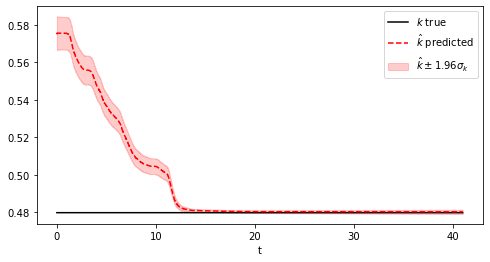

In [15]:
#%% Parameter
plt.figure(figsize = [8,4])
plt.plot(t_axis[n_start_plot:n_stop_plot],inp[n_start_plot:n_stop_plot,6], 'k', label = r"$k$ true")
plt.plot(t_axis[n_start_plot:n_stop_plot],xhat_taxis[4,n_start_plot:n_stop_plot],'r--', label = r"$\hat{k}$ predicted")
plt.fill_between(t_axis[n_start_plot:n_stop_plot], xhat_taxis_piu_sigma[4,n_start_plot:n_stop_plot], xhat_taxis_meno_sigma[4,n_start_plot:n_stop_plot], color='red', alpha=0.2, label = r"$\hat{k} \pm 1.96\sigma_k$")
plt.xlabel('t')
plt.legend()
plt.show()

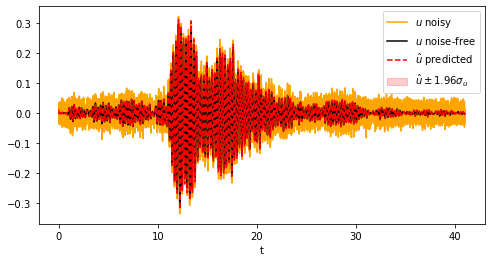

In [16]:
#%% displacement
plt.figure(figsize = [8,4])
plt.plot(t_axis[n_start_plot:n_stop_plot],inp[n_start_plot:n_stop_plot,0], color = 'orange', label=f"$u$ noisy")
plt.fill_between(t_axis[n_start_plot:n_stop_plot], xhat_taxis_piu_sigma[0,n_start_plot:n_stop_plot], xhat_taxis_meno_sigma[0,n_start_plot:n_stop_plot], color='red', alpha=0.2, label=f"$\hat{{u}} \\pm 1.96\sigma_u$")
if add_noise:
    plt.plot(t_axis[n_start_plot:n_stop_plot],inp_no_noise[n_start_plot:n_stop_plot,0],'k',label=f"$u$ noise-free")
plt.plot(t_axis[n_start_plot:n_stop_plot],xhat_taxis[0,n_start_plot:n_stop_plot],'r--', label=f"$\hat{{u}}$ predicted")
plt.legend()
plt.xlabel('t')
plt.show()

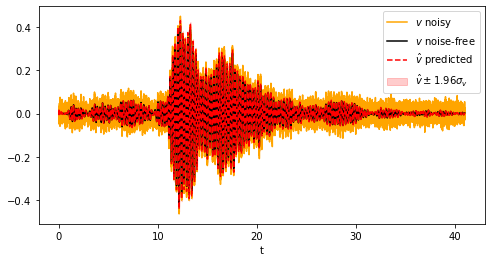

In [17]:
#%% velocity
plt.figure(figsize = [8,4])
plt.plot(t_axis[n_start_plot:n_stop_plot],inp[n_start_plot:n_stop_plot,2], color = 'orange', label=f"$v$ noisy")
plt.fill_between(t_axis[n_start_plot:n_stop_plot], xhat_taxis_piu_sigma[2,n_start_plot:n_stop_plot], xhat_taxis_meno_sigma[2,n_start_plot:n_stop_plot], color='red', alpha=0.2, label=f"$\hat{{v}} \\pm 1.96\sigma_v$")
if add_noise:
    plt.plot(t_axis[n_start_plot:n_stop_plot],inp_no_noise[n_start_plot:n_stop_plot,2],'k',label=f"$v$ noise-free")
plt.plot(t_axis[n_start_plot:n_stop_plot],xhat_taxis[2,n_start_plot:n_stop_plot],'r--', label=f"$\hat{{v}}$ predicted")
plt.legend()
plt.xlabel('t')
plt.show()


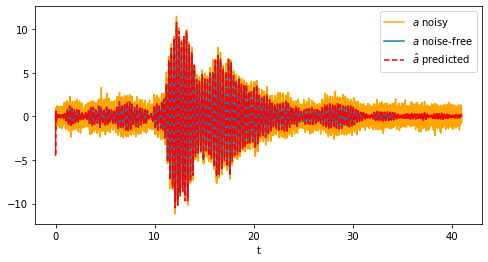

In [18]:
#%% acceleration
plt.figure(figsize = [8,4])
plt.plot(t_axis[n_start_plot:n_stop_plot],inp[n_start_plot:n_stop_plot,4],'orange', label=f"$a$ noisy")
if add_noise:
    plt.plot(t_axis[n_start_plot:n_stop_plot],inp_no_noise[n_start_plot:n_stop_plot,4],label=f"$a$ noise-free")
plt.plot(t_axis[n_start_plot:n_stop_plot],a_axis[0,n_start_plot:n_stop_plot],'r--', label=f"$\hat{{a}}$ predicted")
plt.legend()
plt.xlabel('t')
plt.show()

In [19]:
#%% Rescale the observation for output representation

inp[:,:N_obs_u] = inp[:,:N_obs_u] * scale_x
xhat_taxis[:N_obs_u,:] = xhat_taxis[:N_obs_u,:] * scale_x
xhat_taxis_piu_sigma[:N_obs_u,:] = xhat_taxis_piu_sigma[:N_obs_u,:] * scale_x
xhat_taxis_meno_sigma[:N_obs_u,:] = xhat_taxis_meno_sigma[:N_obs_u,:] * scale_x

inp[:,:N_o] = inp[:,:N_o] * scale_V
inp[:,N_o:N_o+N_param] = inp[:,N_o:N_o+N_param] * scale_param
inp[:,-N_f:] = inp[:,-N_f:] * scale_F

xhat_taxis[:N_ou+N_ov,:] = xhat_taxis[:N_ou+N_ov,:] * scale_V
xhat_taxis[-N_param:,:] = xhat_taxis[-N_param:,:] * scale_param
xhat_taxis_piu_sigma[-N_param:,:] = xhat_taxis_piu_sigma[-N_param:,:] * scale_param
xhat_taxis_meno_sigma[-N_param:,:] = xhat_taxis_meno_sigma[-N_param:,:] * scale_param
xhat_taxis_piu_sigma[:N_ou+N_ov,:] = xhat_taxis_piu_sigma[:N_ou+N_ov,:] * scale_V
xhat_taxis_meno_sigma[:N_ou+N_ov,:] = xhat_taxis_meno_sigma[:N_ou+N_ov,:] * scale_V
a_axis = a_axis *scale_V

if add_noise:
    inp_no_noise[:,:N_o] = inp_no_noise[:,:N_o] * scale_V
    inp_no_noise[:,N_o:N_o+N_param] = inp_no_noise[:,N_o:N_o+N_param] * scale_param
    inp_no_noise[:,-N_f:] = inp_no_noise[:,-N_f:] * scale_F
    inp_no_noise[:,:N_obs_u] = inp_no_noise[:,:N_obs_u] * scale_x